<center><b>DIGHUM101</b></center>
<center>3-4: Network analysis</center>

---

In [53]:
import praw
import os
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Network Analysis

Let's access the Reddit API to do a small network analysis of "influencers" in our data. First, you will need to sign up with Reddit to run some of the code. See **notebook 3-3** for details on how to create an app using the API. 

Go to https://ssl.reddit.com/prefs/apps/ if you need to check your client id and password.

In [54]:
reddit = praw.Reddit(client_id='7NFJdUWLAhWUkgvglV6I6Q',
                     client_secret='acyjbjdwWqCXC3-nzqmWTWDyBfDVtg',
                     password='XXX',
                     user_agent='dh by /u/samwachtman', 
                     username='samwachtman'
                    )

## Network analysis: finding influencers in Reddit data

When getting Reddit data, one cannot at a glance see which users are influential. Other social media platforms have follower counts which directly quantify the amount of reach a user is likely to have, while redditors only have karma, i.e., the net total up and down votes since account creation, and a log of their posts and comments in different subreddits. These twose statistics can give a rough idea of a user’s activity.

It has already been found that a very small percentage of Reddit’s users create the vast majority of the site’s content, so we would not be surprised if only a few users could influence the discourse of entire subreddits. Identifying these users would help us understand how a subreddit's discourse is shaped. 

In [55]:
df = pd.read_csv('../../Data/r_conspiracy.csv')

In [56]:
df.head(3)

,idint,idstr,created,nsfw,author,title,score,distinguish,textlen,num_comments,flair_text,flair_css_class
0,17101205,t3_a6jdh,1258747007,0.0,Hangly,[BREAKING!] Hackers bust open climate change s...,270.0,NaN,728.0,246.0,NaN,NaN
1,22458215,t3_ddcvb,1284409649,0.0,jubal_early,Does anyone else feel that a lot of conspiracy...,200.0,NaN,116.0,120.0,NaN,NaN
2,23799020,t3_e63fw,1289776672,0.0,jqpeub,"""The purpose of the term 'Conspiracy Theory' i...",332.0,NaN,142.0,129.0,NaN,NaN


First, let's get rid of some empty values in our "author" column, using the `dropna()` method. On Reddit, removed posts get flagged as "[removed]" or "[deleted]", so we have to get rid of this too. We can do that with the `isin()` method.

In [57]:
df = df[~df['author'].isin(['None', '[removed]', '[deleted]' ])].dropna(subset=['author'])


In [58]:
df.author.count()

9830

Let's sort by score and just get the top 1000 posts.

In [59]:
df = df.sort_values(by='score',ascending=False)[:1000]

How many unique authors do we have in our data?

In [60]:
df['author'].nunique()

801

<AxesSubplot:xlabel='score', ylabel='num_comments'>

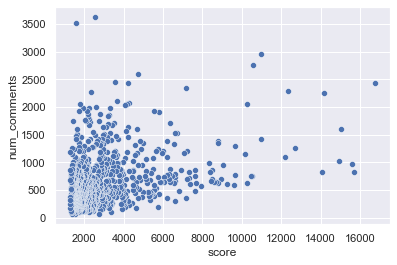

In [61]:
sns.scatterplot(x=df.score, y=df.num_comments)

Note that this scatter plot shows that the number of comments don’t necessarily increase with posts that have a higher net score.

Next, we need to decide which of these users we consider to be "influencers". Let's first have a look at how often these popular authors are posting. We'll select users who have posted to this subreddit (which, remember, is sorted based on popularity) more than twice.

In [62]:
g = df.groupby('author')
rep = g.filter(lambda x: len(x) > 2)

In [63]:
# Out of all posts, this is the amount of people who posted more than twice 
rep.author.nunique() 

39

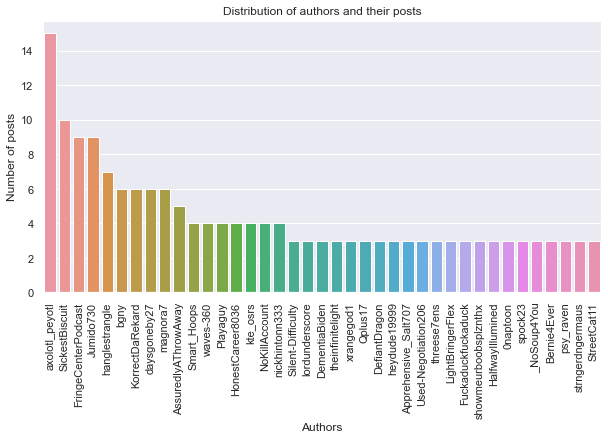

In [64]:
# Plot it
fig, ax = plt.subplots(figsize=(10, 5))

p = sns.countplot(x=rep.author, data=rep, order = rep.author.value_counts().index)
p.set(title='Distribution of authors and their posts',xlabel="Authors", ylabel="Number of posts");
plt.xticks(rotation=90);

>NOTE: Deciding who is an "influencer" of course has to do with the size of the subreddit and how often submissions are made. Feel free to play around with this.

In [65]:
# The top three most frequently posting authors
rep.author.value_counts().index[:3]

Index(['axolotl_peyotl', 'SickestBiscuit', 'FringeCenterPodcast'], dtype='object')

# Back to the API

Next, let's find out where else these influencers posted. We'll compile a list of authors that appeared more than once on other subreddits using the Reddit API. In order to form a network graph, we need data about the particular subreddits where our influencers appeared. 

Let's first define a function that can get us the other posts by the influencers we have found in our data.

In [66]:
def get_user_posts(author, n):
    try:
        redditor = reddit.redditor(author)
        user_posts_list = []
        for submission in redditor.submissions.top(limit = n):
            info_list = []
            info_list.append(submission.id)
            info_list.append(submission.score)
            info_list.append(str(submission.author))
            info_list.append(submission.num_comments)
            info_list.append(str(submission.subreddit))
            user_posts_list.append(info_list)
    # Dealing with errors in case redditors have been banned, deleted their accounts, etc.
    except:
        pass

    a = sorted(user_posts_list, key=lambda x: x[1], reverse = True)
    user_posts_df = pd.DataFrame(a)
    return user_posts_df

In [67]:
u_authors = list(rep.author.unique()) # Get a list of all the unique authors
authors_df =  pd.DataFrame() # Make an empty dataframe
authors_df = authors_df.fillna(0) # Fill it up for now
for u in u_authors: # Loops through every "influencer" user and gets 10 top posts per user
    c = get_user_posts(u, 10)
    authors_df = pd.concat([authors_df, c]) 

In [68]:
authors_df = authors_df.rename(index=str, #renaming column names 
                               columns={0: "id", 1: "score", 2: "author", 3: "num_comments", 4: "subreddit"})

In [69]:
authors_df.tail(20) # Dataframe of other subreddits where authors posted 

""


Now let's visualize those subreddits with at least 2 or more posts made by the influencers. The Y-axis is the number of submissions and the X-axis are the respective subreddits.

In [70]:
counts = authors_df['subreddit'].value_counts() 

# Only plot the subreddits that appear more than twice
ax = authors_df[authors_df['subreddit'].isin(counts[counts > 2].index)].subreddit.value_counts().plot(kind='bar',title='Distribution of other subreddits where influencers post') 
ax.set(xlabel="Subreddits", ylabel="Number of posts")
plt.savefig("BargraphSubreddits",dpi=150, bbox_inches='tight',pad_inches=0.5)

KeyError: 'subreddit'

# Network Analysis

First, we'll create a dataframe where each row represents an influencer and a subreddit they have posted in.

In [ ]:
n_df = authors_df[['author', 'subreddit']] # Create a dataframe for network graph purposes 
n_df.head(10)

In [ ]:
# We can save this to a CSV if we want
n_df.to_csv('r_conspiracy_edges')

## Visualize using NetworkX

In [ ]:
subs = list(n_df.subreddit.unique()) # Make list of unique subreddits to use in network graph 
auths = list(n_df.author.unique()) # Make list of unique authors to use in network graph 

In [ ]:
import networkx as nx

plt.figure(figsize=(18, 18))

# Create the graph from the dataframe
g = nx.from_pandas_edgelist(n_df, source='author', target='subreddit') 

# Create a layout for nodes 
layout = nx.spring_layout(g,iterations=50,scale=2)

# Draw the parts we want, edges thin and grey
# Influencers appear small and grey
# Subreddits appear in blue and sized according to their respective number of connections.
# Labels for subreddits ONLY
# People who have more connections are highlighted in color 

# Go through every subbreddit, ask the graph how many connections it has. 
# Multiply that by 80 to get the circle size
sub_size = [g.degree(sub) * 80 for sub in subs]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=subs, 
                       node_size=sub_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# Draw all the entities 
nx.draw_networkx_nodes(g, layout, nodelist=authors_df['author'], node_color='#cccccc', node_size=100)

# Draw highly connected influencers 
influencers = [person for person in authors_df['author'] if g.degree(person) > 1]
nx.draw_networkx_nodes(g, layout, nodelist=influencers, node_color='orange', node_size=100)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(subs, subs)) #labels for subs
auth_labels = dict(zip(auths, auths)) #labels for authors

nx.draw_networkx_labels(g, layout, labels=node_labels)
nx.draw_networkx_labels(g, layout, labels=auth_labels)


# No axis needed
plt.axis('off')
plt.title("Network Graph of Related Subreddits")
plt.savefig("NetworkGraph", bbox_inches='tight',pad_inches=0.5)
plt.show()

# Interpreting the graph
In this graph, influencer nodes appear small and grey. The influencers who have more connections than just r/conspiracy are highlighted in yellow. The subreddits appear in blue and sized according to their respective number of connections.